In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import xarray as xr
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deeprec  # noqa
from deeprec.utils import ROOT_DIR

In [2]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "docs/figures/si"

In [3]:
# Load inputs and targets
inps = xr.open_zarr(ROOT_DIR / "data/processed/inputs.zarr")
tgts = xr.open_zarr(ROOT_DIR / "data/processed/targets.zarr")

# Merge inputs and targets
ds_all = xr.merge([inps, tgts])

## Input patches

In [4]:
inputs_verbose = {
    "cell_area": "Grid cell area",
    "nvec_x": "n-vector, X",
    "nvec_y": "n-vector, Y",
    "nvec_z": "n-vector, Z",
    "era5_tp": "Total precipitation",
    # "era5_e": "Evaporation",
    # "era5_pev": "Potential evap.",
    "era5_sp": "Surface pressure",
    # "era5_sro": "Surface runoff",
    # "era5_ssro": "Sub-surface runoff",
    "era5_t2m": "Temperature 2m",
    # "era5_d2m": "Dewpoint temp 2m",
    # "era5_lai_hv": "LAI, high",
    # "era5_lai_lv": "LAI, low",
    # "era5_cvh": "High veg cover",
    # "era5_cvl": "Low veg cover",
    "era5_sd": "Snow depth",
    # "era5_swvl1": "Soil water, lyr 1",
    # "era5_swvl2": "Soil water, lyr 2",
    # "era5_swvl3": "Soil water, lyr 3",
    # "era5_swvl4": "Soil water, lyr 4",
    "cropland_rainfed": "Cropland, rainfed",
    "cropland_irrigated": "Cropland, irrigated",
    "pastures": "Pastures",
    "urbanareas": "Urban areas",
    "lakes": "Lake area",
    # "twsa_gap": "WaterGAP TWSA",
    # "year_cos": "Annual, cosine",
    # "year_sin": "Annual, sine",
    # "year2_cos": "Semi-annual, cosine",
    # "year2_sin": "Semi-annual, sine",
    # "oni": "Oceanic Niño Index (ONI)",
    "twsa_csr": "CSR Mascon (Target)",
}
print(f"{len(inputs_verbose) = }")


len(inputs_verbose) = 14


In [5]:
# Amazon
# LAT_CENTER = -2.25
# LON_CENTER = -55.25
# Canada
LAT_CENTER = 42.25
LON_CENTER = -118.25
# Half patch extension in degrees
PATCH_EXT = 8.5
lat_slice = slice(LAT_CENTER + PATCH_EXT, LAT_CENTER - PATCH_EXT)
lon_slice = slice(LON_CENTER - PATCH_EXT, LON_CENTER + PATCH_EXT)
inputs = (
    ds_all[inputs_verbose.keys()]
    .sel(time="2020-06-01", lat=lat_slice, lon=lon_slice)
    .to_dataarray("feature")
)

In [6]:
ncols = 4
features = len(inputs_verbose)
nrows = int(np.ceil(features / ncols))


In [7]:
formatter = mpl.ticker.ScalarFormatter()
formatter.set_scientific(True)
cbar_kwargs = dict(
    location="right",
    aspect=10,
    shrink=0.8,
    format=formatter,
)
locator = mpl.ticker.MultipleLocator(10)


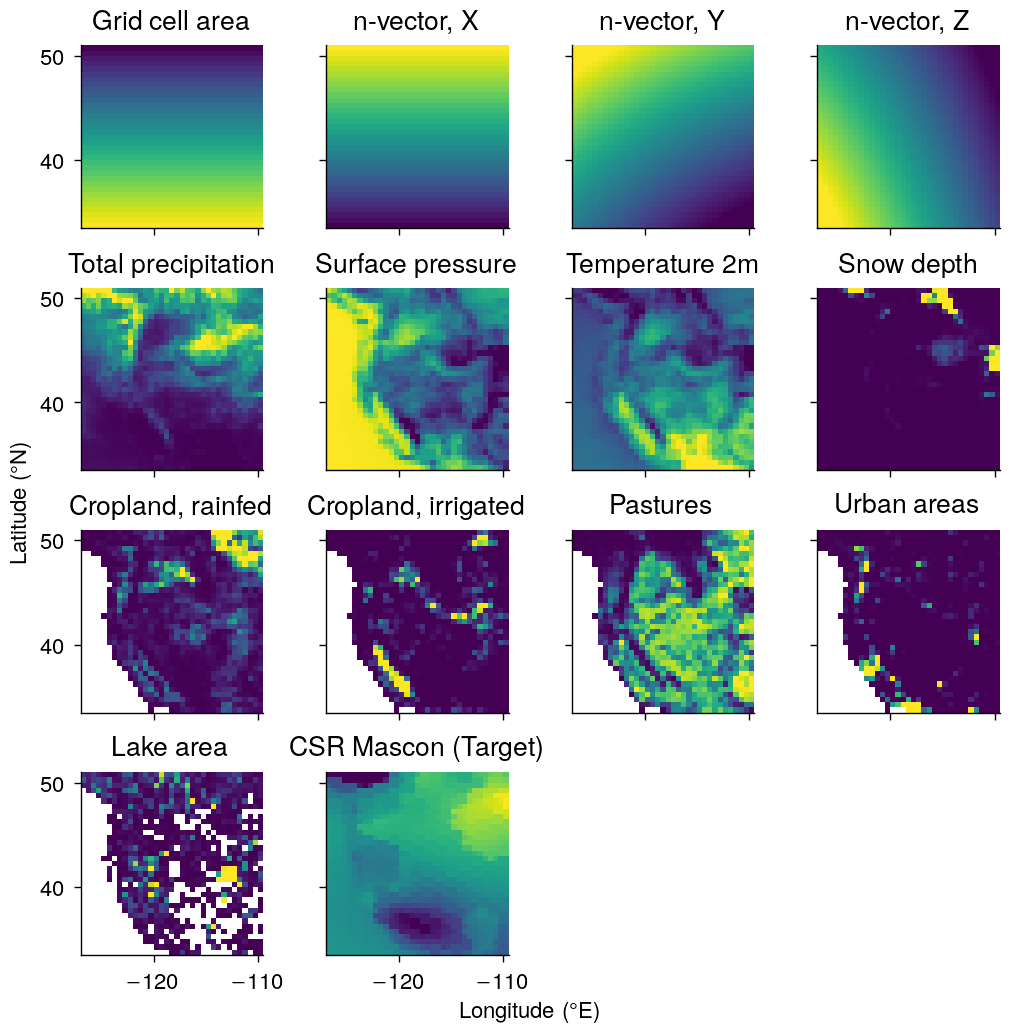

In [8]:
fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    # figsize=(5, 7),
    figsize=(5, 5),
)

for ax in axs.flat:
    ax.set_axis_off()

for i, (ax, feat) in enumerate(zip(axs.flat, inputs.feature.values)):
    if feat == "twsa_gap":
        vmin = -400
        vmax = 400
    elif feat.startswith("era5_swvl"):
        vmin = 0.0
        vmax = 0.5
    elif feat == "era5_pev":
        vmin = -0.006
        vmax = 0.00
    else:
        vmin = None
        vmax = None
    # Evaporation are defined negatively - reverse colormap
    cmap = "viridis_r" if feat == "era5_e" or feat == "era5_pev" else "viridis"

    ax.set_axis_on()
    data = inputs.sel(feature=feat)
    data.plot.pcolormesh(
        ax=ax,
        robust=True,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
        add_colorbar=False,
        rasterized=True,
    )
    ax.set(
        title=inputs_verbose[feat],
        aspect="equal",
        xlabel=None,
        ylabel=None,
    )

    ax.yaxis.set_major_locator(locator)
    ax.label_outer()

# Set common labels
fig.text(0.5, 0, "Longitude (°E)", ha="center", va="top")
fig.text(0, 0.5, "Latitude (°N)", ha="right", va="center", rotation="vertical")

fig.savefig(FIGURE_DIR / "input_patches.pdf", backend="pgf")